# Super store statistics

## Libraries

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import norm, skew, kurtosis, anderson, kstest
import fitter
from fitter import Fitter, get_common_distributions, get_distributions
import seaborn as sns

In [ ]:
data = pd.read_csv("order_detail.csv")
category = pd.read_csv("category.csv")
data = pd.merge(data, category, on='Product ID')

data['has_discount'] = (data['Discount'] > 0).astype(int)

has_discount_df = data.loc[data['has_discount'] == 1, :]
has_discount_df.head


In [47]:
discounted_ids = has_discount_df['Product ID'].tolist()

# Filter the non-discounted products in data that have a corresponding discounted product in has_discount
non_discounted_df = data.loc[(data['Product ID'].isin(discounted_ids)) & (data['has_discount'] == 0), :]

#result_df = non_discounted_df.loc[non_discounted_df['Product ID'] == 'OFF-HAR-10001948', :]
# Print the resulting dataframe
#print(result_df)

In [48]:
# use the IQR method to remove outliers
Q1 = has_discount_df['Quantity'].quantile(0.25)
Q3 = has_discount_df['Quantity'].quantile(0.75)
IQR = Q3 - Q1
rslt_df = has_discount_df[(has_discount_df['Quantity'] >= Q1 - 1.5*IQR) & (has_discount_df['Quantity'] <= Q3 + 1.5*IQR)]


In [ ]:
#apc = rslt_df["Quantity"].values
apc = has_discount_df.groupby('Product ID')['Quantity'].mean()
dist = get_common_distributions()
print(dist)
f = Fitter(apc, distributions= dist)
f.fit()
f.summary()


Fitting 2 distributions: 100%|██████████| 2/2 [00:03<00:00,  1.66s/it]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
pearson3,23.232555,512.893228,-144457.963483,inf,0.204919,0.000000e+00
lognorm,23.638671,517.620932,-144090.613822,inf,0.129953,1.400692e-312


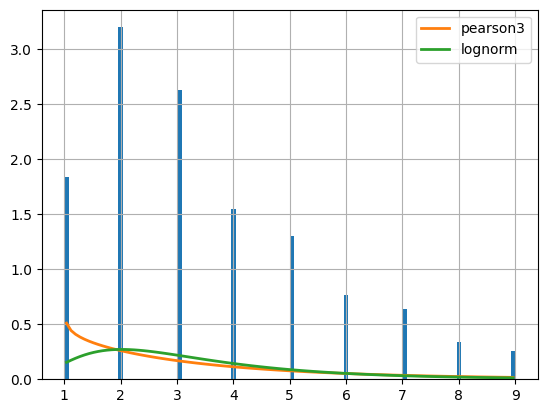

In [22]:

apc = rslt_df["Quantity"].values

f = Fitter(apc,
           distributions=['lognorm',
                          'pearson3',])

f.fit()
f.summary()


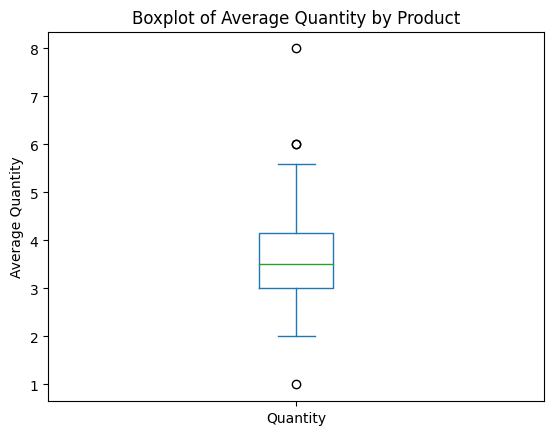

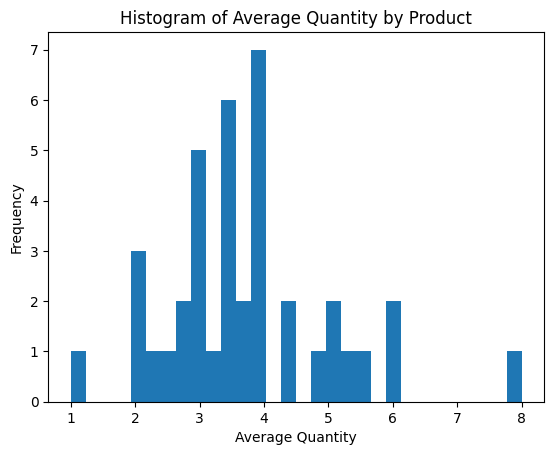

In [54]:
# group by product id and calculate the average quantity for each group
avg_quantity = has_discount_df.groupby('Category')['Quantity'].mean()
avg_quantity = avg_quantity.round(decimals=1)

# create a boxplot of the average quantity by product id
avg_quantity.plot(kind='box')
plt.title('Boxplot of Average Quantity by Product')
plt.ylabel('Average Quantity')
plt.show()
# create a histogram of the average quantity by product id
avg_quantity.plot(kind='hist', bins=30)
plt.title('Histogram of Average Quantity by Product')
plt.xlabel('Average Quantity')
plt.show()

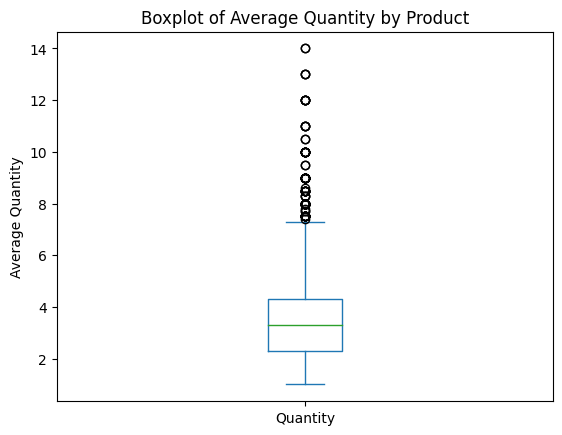

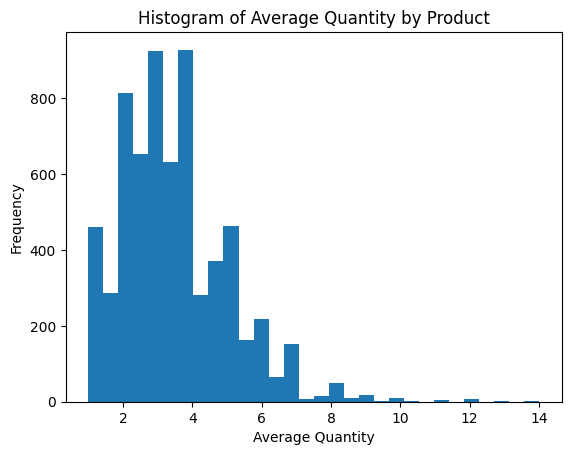

In [34]:
# group by product id and calculate the average quantity for each group
undis_avg_quantity = non_discounted_df.groupby('Product ID')['Quantity'].mean()
undis_avg_quantity = undis_avg_quantity.round(decimals=1)

# create a boxplot of the average quantity by product id
undis_avg_quantity.plot(kind='box')
plt.title('Boxplot of Average Quantity by Product')
plt.ylabel('Average Quantity')
plt.show()
# create a histogram of the average quantity by product id
undis_avg_quantity.plot(kind='hist', bins=30)
plt.title('Histogram of Average Quantity by Product')
plt.xlabel('Average Quantity')
plt.show()

In [ ]:
print(avg_quantity)

In [ ]:
has_discount_df.head

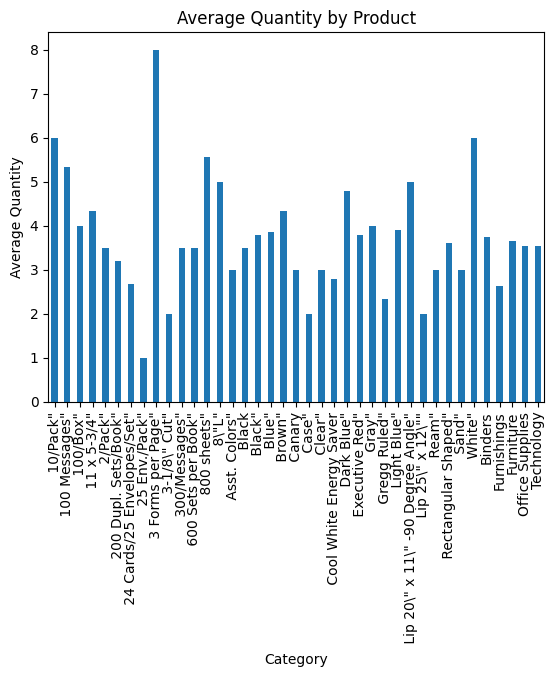

In [59]:
# group by product id and calculate the average quantity for each group
avg_quantity = has_discount_df.groupby('Category')['Quantity'].mean()
undis_avg_quantity = non_discounted_df.groupby('Category')['Quantity'].mean()
# round up the average quantity values to 2 decimal places
avg_quantity = avg_quantity.round(decimals=2)
undis_avg_quantity = avg_quantity.round(decimals=2)
# create a bar plot of the average quantity by product id
avg_quantity.plot(kind='bar')
undis_avg_quantity.plot(kind='bar')
plt.title('Average Quantity by Product')
plt.xlabel('Category')
plt.ylabel('Average Quantity')
plt.show()


In [ ]:
# group by product id and calculate the average quantity for each group
avg_quantity = has_discount_df.groupby(['Category'])['Quantity'].mean()
avg_quantity = pd.DataFrame(avg_quantity).reset_index()
avg_profit = has_discount_df.groupby(['Category'])['Profit'].mean()
avg_profit = pd.DataFrame(avg_profit).reset_index()

undis_avg_quantity = non_discounted_df.groupby(['Category'])['Quantity'].mean()
undis_avg_quantity = pd.DataFrame(undis_avg_quantity).reset_index()
undis_avg_profit =  non_discounted_df.groupby(['Category'])['Profit'].mean()
undis_avg_profit = pd.DataFrame(undis_avg_profit).reset_index()


profit_merged_df = pd.merge(undis_avg_profit, avg_profit, on='Category')
quantity_merged_df = pd.merge(undis_avg_quantity, avg_quantity, on='Category')

# create a grouped bar chart of the merged data
#print(quantity_merged_df)

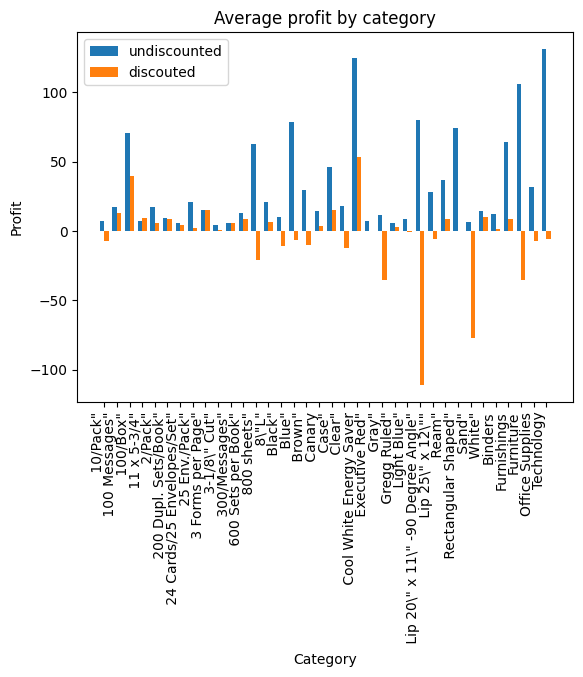

In [119]:
# create a grouped bar chart of the merged data
fig, ax = plt.subplots()
bar_width = 0.35
x = range(len(profit_merged_df))
ax.bar(x, profit_merged_df['Profit_x'], width=bar_width, label='undiscounted')
ax.bar([i + bar_width for i in x], profit_merged_df['Profit_y'], width=bar_width, label='discouted')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(profit_merged_df['Category'], rotation=90, ha='right')
ax.set_title('Average profit by category')
ax.set_xlabel('Category')
ax.set_ylabel('Profit')
ax.legend()
plt.show()

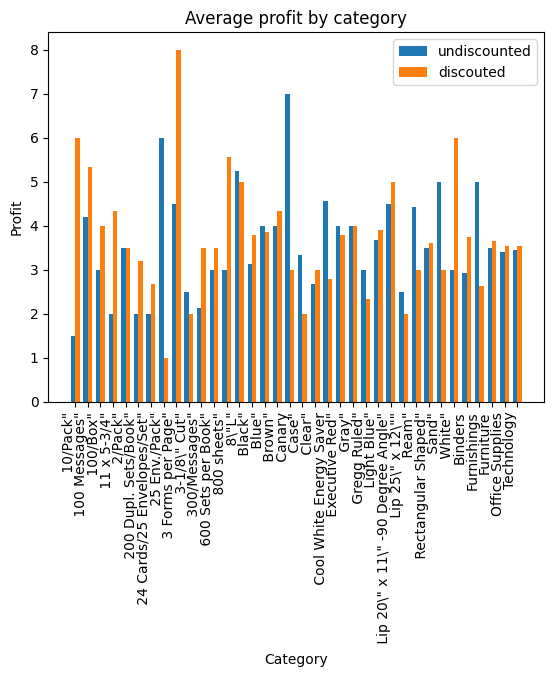

In [153]:
# create a grouped bar chart of the merged data
fig, ax = plt.subplots()
bar_width = 0.35
x = range(len(quantity_merged_df))
ax.bar(x, quantity_merged_df['Quantity_x'], width=bar_width, label='undiscounted')
ax.bar([i + bar_width for i in x], quantity_merged_df['Quantity_y'], width=bar_width, label='discouted')
ax.set_xticks([i + bar_width / 2 for i in x])
ax.set_xticklabels(quantity_merged_df['Category'], rotation=90, ha='right')
ax.set_title('Average profit by category')
ax.set_xlabel('Category')
ax.set_ylabel('Profit')
ax.legend()
plt.show()


In [144]:
# perform a left-anti join to identify the rows that are in `discounted_df` but not in `undiscounted_df`
p_left_anti_df = avg_profit.merge(undis_avg_profit, on='Category', how='left', indicator=True)
p_left_anti_df = p_left_anti_df.loc[p_left_anti_df['_merge'] == 'left_only']
p_left_anti_df['Profit_y'].fillna(0, inplace=True)

# print the resulting left-anti join dataframe
print(p_left_anti_df)

          Category   Profit_x  Profit_y     _merge
14   Asst. Colors"  -1.297000       0.0  left_only
15           Black  15.640733       0.0  left_only
23      Dark Blue"   2.636520       0.0  left_only


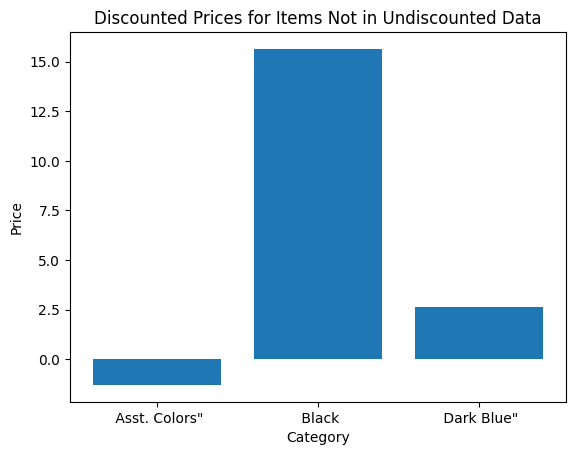

In [147]:
fig, ax = plt.subplots()
ax.bar(p_left_anti_df['Category'], p_left_anti_df['Profit_x'])
ax.set_xlabel('Category')
ax.set_ylabel('Price')
ax.set_title('Profit')
plt.show()

In [149]:
# perform a left-anti join to identify the rows that are in `discounted_df` but not in `undiscounted_df`
q_left_anti_df = avg_quantity.merge(undis_avg_quantity, on='Category', how='left', indicator=True)
q_left_anti_df = q_left_anti_df.loc[q_left_anti_df['_merge'] == 'left_only']
q_left_anti_df['Quantity_y'].fillna(0, inplace=True)

# print the resulting left-anti join dataframe
print(q_left_anti_df)

          Category  Quantity_x  Quantity_y     _merge
14   Asst. Colors"         3.0         0.0  left_only
15           Black         3.5         0.0  left_only
23      Dark Blue"         4.8         0.0  left_only


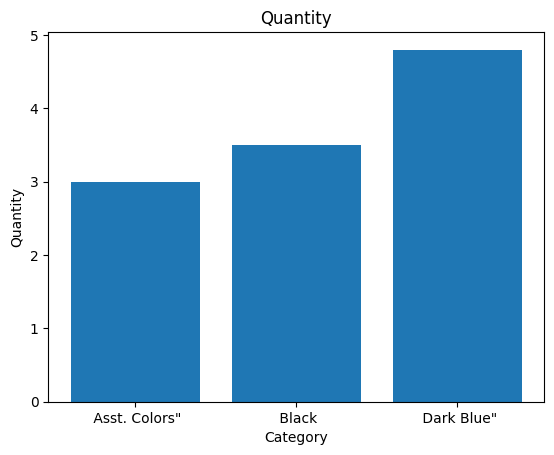

In [150]:
fig, ax = plt.subplots()
ax.bar(q_left_anti_df['Category'], q_left_anti_df['Quantity_x'])
ax.set_xlabel('Category')
ax.set_ylabel('Quantity')
ax.set_title('Quantity')
plt.show()